### PRODUCT CLUSTERING ANALYSIS - COMPLETE PIPELINE

In [ ]:
import pandas as pd
import numpy as np
import seaborn as sns
from sklearn.preprocessing import RobustScaler
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score

In [ ]:
import matplotlib
matplotlib.use('TkAgg')  
import matplotlib.pyplot as plt

In [ ]:
from sqlalchemy import create_engine
from dotenv import load_dotenv
from os import getenv

In [ ]:
load_dotenv(".env")
engine = create_engine(getenv("DB_URL"))

In [ ]:
df = pd.read_sql("SELECT * FROM sales219", engine)

### 1. DATA CLEANING & PREPARATION

In [8]:
df.shape

(3678038, 17)

In [9]:
df.columns

Index(['TRANSACTION_RK', 'CALENDAR_DT', 'date', 'time', 'TRANSACTION_TM',
       'ITEM_SK', 'RETAIL_OUTLET_LOCATION_SK', 'POS_TERMINAL_NO', 'CASHIER_NO',
       'ITEM_QTY', 'ITEM_WEIGHT', 'SALES_UOM_CD', 'SELLING_RETAIL_AMT',
       'PROMO_SALES_IND_CD', 'STAPLE_ITEM_FLG', 'REGION_CD', 'CUSTOMER_SK'],
      dtype='object')

In [10]:
df.head()

,TRANSACTION_RK,CALENDAR_DT,date,time,TRANSACTION_TM,ITEM_SK,RETAIL_OUTLET_LOCATION_SK,POS_TERMINAL_NO,CASHIER_NO,ITEM_QTY,ITEM_WEIGHT,SALES_UOM_CD,SELLING_RETAIL_AMT,PROMO_SALES_IND_CD,STAPLE_ITEM_FLG,REGION_CD,CUSTOMER_SK
0,6711099404,01JAN2015,2015-01-01,0 days 22:51:50,22:51:50,12519213,219,7,116,1,0.000,U,6.990,R,Y,4,1
1,6712905826,02JAN2015,2015-01-02,0 days 14:10:33,14:10:33,11838638,219,6,260,1,0.000,U,3.090,R,Y,4,1
2,6712906309,02JAN2015,2015-01-02,0 days 16:48:32,16:48:32,11627223,219,9,212,1,0.000,U,5.490,R,N,4,1
3,6712907445,02JAN2015,2015-01-02,0 days 20:01:05,20:01:05,11840452,219,6,132,1,0.000,U,1.250,N,N,4,1
4,6712905166,02JAN2015,2015-01-02,0 days 07:38:03,7:38:03,14199100,219,6,121,1,0.000,N,4.990,R,N,4,1


In [26]:
# Make a copy to preserve original data
df_clean = df.copy()

In [14]:
# Check for missing values
print("Missing values per column:")
missing_data = df_clean.isnull().sum()
print(missing_data[missing_data > 0])

Missing values per column:
Series([], dtype: int64)


In [25]:
df.dtypes

TRANSACTION_RK                        object
CALENDAR_DT                           object
date                                  object
time                         timedelta64[ns]
TRANSACTION_TM                        object
ITEM_SK                               object
RETAIL_OUTLET_LOCATION_SK              int64
POS_TERMINAL_NO                        int64
CASHIER_NO                             int64
ITEM_QTY                               int64
ITEM_WEIGHT                          float64
SALES_UOM_CD                          object
SELLING_RETAIL_AMT                   float64
PROMO_SALES_IND_CD                    object
STAPLE_ITEM_FLG                       object
REGION_CD                              int64
CUSTOMER_SK                           object
dtype: object

In [40]:
# Ensure data types are correct
df_clean['date'] = pd.to_datetime(df_clean['date'])

In [41]:
df_clean.dtypes

TRANSACTION_RK                        object
CALENDAR_DT                           object
date                          datetime64[ns]
time                         timedelta64[ns]
TRANSACTION_TM                        object
ITEM_SK                               object
RETAIL_OUTLET_LOCATION_SK              int64
POS_TERMINAL_NO                        int64
CASHIER_NO                             int64
ITEM_QTY                               int64
ITEM_WEIGHT                          float64
SALES_UOM_CD                          object
SELLING_RETAIL_AMT                   float64
PROMO_SALES_IND_CD                    object
STAPLE_ITEM_FLG                       object
REGION_CD                              int64
CUSTOMER_SK                           object
line_revenue                         float64
visit_id                              object
dtype: object

In [27]:

# See examples of rows with ITEM_QTY <= 0
print("\n=== Sample rows with ITEM_QTY <= 0 ===")
print(df_clean[df_clean['ITEM_QTY'] <= 0].head(10))

# See examples of rows with SELLING_RETAIL_AMT <= 0
print("\n=== Sample rows with SELLING_RETAIL_AMT <= 0 ===")
print(df_clean[df_clean['SELLING_RETAIL_AMT'] <= 0].head(10))

# See examples of rows with null CUSTOMER_SK
print("\n=== Sample rows with null CUSTOMER_SK ===")
print(df_clean[df_clean['CUSTOMER_SK'].isna()].head(10))


=== Sample rows with ITEM_QTY <= 0 ===
    TRANSACTION_RK CALENDAR_DT        date            time TRANSACTION_TM  \
60      6712905552   02JAN2015  2015-01-02 0 days 12:32:20       12:32:20   
99      6712905896   02JAN2015  2015-01-02 0 days 15:00:22       15:00:22   
108     6711099403   01JAN2015  2015-01-01 0 days 21:05:05       21:05:05   
304     6712928401   02JAN2015  2015-01-02 0 days 09:34:12        9:34:12   
539     6712905697   02JAN2015  2015-01-02 0 days 13:52:35       13:52:35   
588     6712905889   02JAN2015  2015-01-02 0 days 14:54:30       14:54:30   
674     6712929693   02JAN2015  2015-01-02 0 days 18:27:06       18:27:06   
751     6713007233   02JAN2015  2015-01-02 0 days 12:53:39       12:53:39   
785     6712907773   02JAN2015  2015-01-02 0 days 21:26:18       21:26:18   
804     6713007071   02JAN2015  2015-01-02 0 days 10:53:38       10:53:38   

      ITEM_SK  RETAIL_OUTLET_LOCATION_SK  POS_TERMINAL_NO  CASHIER_NO  \
60   11743876                        21

In [28]:
# Filter out invalid transactions
initial_count = len(df_clean)
df_clean = df_clean[
    (df_clean['ITEM_QTY'] > 0) & 
    (df_clean['SELLING_RETAIL_AMT'] > 0)
]

In [29]:
print(f"Rows after filtering invalid transactions: {len(df_clean)}")
print(f"Removed {initial_count - len(df_clean)} invalid rows")

Rows after filtering invalid transactions: 3482091
Removed 195947 invalid rows


In [30]:
# Calculate line total revenue
df_clean['line_revenue'] = df_clean['ITEM_QTY'] * df_clean['SELLING_RETAIL_AMT']

### 3. FEATURE ENGINEERING

In [31]:
# Define what constitutes a "visit" - using TRANSACTION_RK as visit identifier
df_clean['visit_id'] = df_clean['TRANSACTION_RK']

In [45]:
# Create product-level features
product_features = df_clean.groupby('ITEM_SK').agg({
    'CUSTOMER_SK': ['nunique'],                    # Distinct customers
    'line_revenue': ['sum', 'mean'],              # Total revenue and avg per transaction line
    'visit_id': ['nunique'],                      # Number of visits
    'ITEM_QTY': ['sum', 'mean'],                  # Total quantity and avg quantity
    'date': ['min', 'max', 'nunique']             # First/last sale date, unique days
}).reset_index()

In [46]:
# Flatten column names
product_features.columns = [
    'product_id',
    'distinct_customers',
    'revenue',
    'avg_line_revenue',
    'number_of_visits',
    'total_quantity',
    'avg_quantity_per_line',
    'first_sale_date',
    'last_sale_date',
    'unique_sale_days'
]

In [47]:
# Calculate derived features
product_features['avg_revenue_per_visit'] = product_features['revenue'] / product_features['number_of_visits']
product_features['avg_revenue_per_customer'] = product_features['revenue'] / product_features['distinct_customers']
product_features['purchase_frequency'] = product_features['number_of_visits'] / product_features['distinct_customers']

In [50]:
# Calculate recency (days since last sale, assuming analysis date is end of 2019)
analysis_date = pd.Timestamp('2026-01-15')
product_features['days_since_last_sale'] = (analysis_date - product_features['last_sale_date'])
product_features['sales_duration_days'] = (product_features['last_sale_date'] - product_features['first_sale_date']).dt.days + 1

In [51]:
# Calculate additional useful metrics
product_features['avg_daily_revenue'] = product_features['revenue'] / product_features['sales_duration_days']
product_features['avg_visit_value'] = product_features['revenue'] / product_features['number_of_visits']
product_features['customer_penetration_rate'] = product_features['distinct_customers'] / product_features['number_of_visits']

In [52]:
print(f"Created features for {len(product_features)} unique products")
print("\nFeature Statistics:")
print(product_features.describe().T[['mean', 'std', 'min', 'max']])

Created features for 30507 unique products

Feature Statistics:
                                                    mean  \
distinct_customers                                53.873   
revenue                                          575.241   
avg_line_revenue                                   6.421   
number_of_visits                                 114.141   
total_quantity                                   134.906   
avg_quantity_per_line                              1.153   
first_sale_date            2015-02-10 21:09:41.650113024   
last_sale_date             2015-08-05 20:34:40.204543232   
unique_sale_days                                  45.909   
avg_revenue_per_visit                              6.421   
avg_revenue_per_customer                          11.205   
purchase_frequency                                 1.764   
days_since_last_sale        3815 days 03:25:19.795456768   
sales_duration_days                              176.976   
avg_daily_revenue                   

### 4. DATA QUALITY CHECK & OUTLIER DETECTION

In [53]:
# Check for infinite or null values
print("Checking for data issues:")
print(f"Rows with NaN values: {product_features.isnull().sum().sum()}")
print(f"Rows with infinite values: {np.isinf(product_features.select_dtypes(include=[np.number])).sum().sum()}")

Checking for data issues:
Rows with NaN values: 0
Rows with infinite values: 0


In [54]:
# Identify extreme outliers using IQR method
def detect_outliers_iqr(df, column, threshold=3):
    Q1 = df[column].quantile(0.25)
    Q3 = df[column].quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - threshold * IQR
    upper_bound = Q3 + threshold * IQR
    outliers = df[(df[column] < lower_bound) | (df[column] > upper_bound)]
    return outliers, lower_bound, upper_bound

In [55]:
outlier_report = {}
print("\nOutlier Detection (using IQR method):")
for col in ['revenue', 'distinct_customers', 'number_of_visits']:
    outliers, lower, upper = detect_outliers_iqr(product_features, col, threshold=3)
    outlier_report[col] = {
        'outlier_count': len(outliers),
        'percentage': len(outliers) / len(product_features) * 100,
        'lower_bound': lower,
        'upper_bound': upper
    }
    print(f"{col}: {len(outliers)} outliers ({len(outliers)/len(product_features)*100:.1f}%)")


Outlier Detection (using IQR method):
revenue: 1994 outliers (6.5%)
distinct_customers: 1838 outliers (6.0%)
number_of_visits: 1953 outliers (6.4%)


In [56]:
# Create a flag for extreme outliers
product_features['is_extreme_outlier'] = False
for col in ['revenue', 'distinct_customers']:
    outliers, _, _ = detect_outliers_iqr(product_features, col, threshold=5)  # More strict for extreme
    product_features.loc[outliers.index, 'is_extreme_outlier'] = True

print(f"\nExtreme outliers (across all metrics): {product_features['is_extreme_outlier'].sum()} products")


Extreme outliers (across all metrics): 1416 products


### 5. FEATURE SELECTION & PREPROCESSING

In [57]:
# Select features for clustering
selected_features = [
    'distinct_customers',
    'revenue', 
    'number_of_visits',
    'avg_revenue_per_visit',
    'avg_revenue_per_customer',
    'purchase_frequency',
    'total_quantity',
    'unique_sale_days',
    'avg_daily_revenue'
]

In [58]:
# Create feature matrix
X = product_features[selected_features].copy()

In [59]:
# Handle zeros (log transformation will fail with zeros)
# Add small constant to enable log transform
X_log = X.copy()
for col in X_log.columns:
    if X_log[col].min() == 0:
        print(f"Adding small constant to column '{col}' to handle zeros for log transform.")
        X_log[col] = X_log[col] + 1e-10

In [60]:
# Apply log transformation to reduce skewness
X_log_transformed = np.log1p(X_log)  # log(1+x) to handle zeros

In [61]:
# Scale the features
scaler = RobustScaler()  # Robust to outliers
X_scaled = scaler.fit_transform(X_log_transformed)

In [62]:
print(f"Selected {len(selected_features)} features for clustering:")
for i, feat in enumerate(selected_features, 1):
    print(f"{i:2}. {feat}")

Selected 9 features for clustering:
 1. distinct_customers
 2. revenue
 3. number_of_visits
 4. avg_revenue_per_visit
 5. avg_revenue_per_customer
 6. purchase_frequency
 7. total_quantity
 8. unique_sale_days
 9. avg_daily_revenue


### 6. DETERMINING OPTIMAL NUMBER OF CLUSTERS (K)

In [63]:
# Try different values of K
k_range = range(2, 11)
inertias = []
silhouette_scores = []

In [64]:
for k in k_range:
    kmeans = KMeans(n_clusters=k, random_state=42, n_init=10)
    cluster_labels = kmeans.fit_predict(X_scaled)
    inertias.append(kmeans.inertia_)
    
    # Silhouette score (skip for k=1 as it's not defined)
    if k > 1:
        silhouette_avg = silhouette_score(X_scaled, cluster_labels)
        silhouette_scores.append(silhouette_avg)
    else:
        silhouette_scores.append(0)

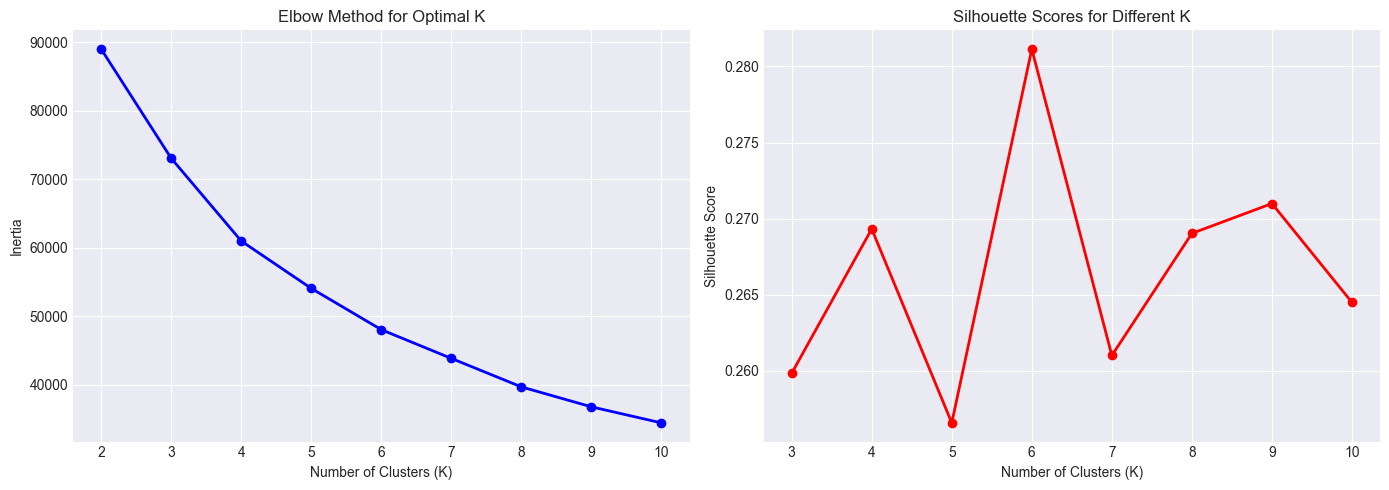

In [65]:
# Plot elbow curve and silhouette scores
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 5))

# Elbow method
ax1.plot(k_range, inertias, 'bo-', linewidth=2)
ax1.set_xlabel('Number of Clusters (K)')
ax1.set_ylabel('Inertia')
ax1.set_title('Elbow Method for Optimal K')
ax1.grid(True)

# Silhouette scores
ax2.plot(k_range[1:], silhouette_scores[1:], 'ro-', linewidth=2)
ax2.set_xlabel('Number of Clusters (K)')
ax2.set_ylabel('Silhouette Score')
ax2.set_title('Silhouette Scores for Different K')
ax2.grid(True)

plt.tight_layout()
plt.savefig('k_selection_analysis.png', dpi=150, bbox_inches='tight')
plt.show()

In [66]:
# Find optimal K (you can adjust this logic)
# Simple heuristic: find elbow point and good silhouette score
inertia_diff = np.diff(inertias)
inertia_ratio = inertia_diff[:-1] / inertia_diff[1:]

In [67]:
optimal_k_elbow = np.argmax(inertia_ratio > 1.5) + 3 if any(inertia_ratio > 1.5) else 4
optimal_k_silhouette = k_range[np.argmax(silhouette_scores[1:]) + 1]

In [68]:
print(f"Suggested K from elbow method: {optimal_k_elbow}")
print(f"Suggested K from silhouette scores: {optimal_k_silhouette}")

Suggested K from elbow method: 4
Suggested K from silhouette scores: 6


In [72]:
# Let's use the silhouette-based K or ask for input
optimal_k = optimal_k_silhouette
print(f"\nUsing K = {optimal_k} for clustering")


Using K = 6 for clustering


### 7. RUNNING K-MEANS CLUSTERING

In [73]:
# Perform K-means clustering
kmeans = KMeans(n_clusters=optimal_k, random_state=42, n_init=20)
product_features['cluster'] = kmeans.fit_predict(X_scaled)

In [74]:
# Get cluster centroids in the scaled space
centroids_scaled = kmeans.cluster_centers_

In [75]:
# Transform centroids back to original scale
centroids_log = scaler.inverse_transform(centroids_scaled)
centroids_original = np.expm1(centroids_log)  # Reverse log(1+x)

In [76]:
# Create centroids DataFrame
centroids_df = pd.DataFrame(
    centroids_original,
    columns=selected_features,
    index=[f'Cluster_{i}' for i in range(optimal_k)]
)

In [77]:
print(f"Clustering complete! Products assigned to {optimal_k} clusters.")
print("\nCluster Distribution:")
cluster_dist = product_features['cluster'].value_counts().sort_index()
for cluster, count in cluster_dist.items():
    print(f"Cluster {cluster}: {count} products ({count/len(product_features)*100:.1f}%)")

Clustering complete! Products assigned to 6 clusters.

Cluster Distribution:
Cluster 0: 4669 products (15.3%)
Cluster 1: 6524 products (21.4%)
Cluster 2: 8729 products (28.6%)
Cluster 3: 4417 products (14.5%)
Cluster 4: 3923 products (12.9%)
Cluster 5: 2245 products (7.4%)


### 8. CLUSTER PROFILING & INTERPRETATION

In [78]:
# Calculate cluster statistics
cluster_profiles = product_features.groupby('cluster')[selected_features].agg(['mean', 'std', 'count'])

In [79]:
# Flatten the multi-level columns for easier viewing
cluster_profiles_flat = pd.DataFrame()
for col in selected_features:
    cluster_profiles_flat[f'{col}_mean'] = cluster_profiles[col]['mean']
    cluster_profiles_flat[f'{col}_std'] = cluster_profiles[col]['std']

In [80]:
# Add cluster size
cluster_profiles_flat['product_count'] = cluster_profiles[selected_features[0]]['count']
cluster_profiles_flat['percentage'] = (cluster_profiles_flat['product_count'] / len(product_features)) * 100

In [81]:
print("\nCluster Profiles (Key Metrics):")
profile_cols = ['product_count', 'percentage', 'revenue_mean', 'distinct_customers_mean', 
                'number_of_visits_mean', 'avg_revenue_per_customer_mean']
print(cluster_profiles_flat[profile_cols].round(2))


Cluster Profiles (Key Metrics):
         product_count  percentage  revenue_mean  distinct_customers_mean  \
cluster                                                                     
0                 4669      15.300      2690.850                  237.740   
1                 6524      21.390        79.560                    6.830   
2                 8729      28.610       300.630                   43.390   
3                 4417      14.480        30.650                    6.960   
4                 3923      12.860       425.410                   19.190   
5                 2245       7.360        16.870                    1.870   

         number_of_visits_mean  avg_revenue_per_customer_mean  
cluster                                                        
0                      540.560                         11.960  
1                        9.590                         12.070  
2                       76.480                          7.400  
3                        9.490

In [82]:
# Create descriptive names for clusters based on characteristics
def assign_cluster_names(cluster_stats):
    cluster_names = {}
    
    for cluster in cluster_stats.index:
        revenue = cluster_stats.loc[cluster, 'revenue_mean']
        customers = cluster_stats.loc[cluster, 'distinct_customers_mean']
        freq = cluster_stats.loc[cluster, 'purchase_frequency_mean']
        
        # Determine cluster type based on metrics
        if revenue > cluster_stats['revenue_mean'].mean() * 1.5:
            if customers > cluster_stats['distinct_customers_mean'].mean() * 1.5:
                name = "Star Products"
            else:
                name = "High-Value Niche"
        elif customers > cluster_stats['distinct_customers_mean'].mean() * 1.5:
            name = "Popular Commodities"
        elif freq > cluster_stats['purchase_frequency_mean'].mean() * 1.5:
            name = "Frequent Purchases"
        elif revenue < cluster_stats['revenue_mean'].mean() * 0.5:
            name = "Low-Performers"
        else:
            name = "Average Products"
        
        cluster_names[cluster] = name
    
    return cluster_names

In [83]:
cluster_names = assign_cluster_names(cluster_profiles_flat)
product_features['cluster_name'] = product_features['cluster'].map(cluster_names)

In [84]:
print("\nAssigned Cluster Names:")
for cluster, name in cluster_names.items():
    count = cluster_profiles_flat.loc[cluster, 'product_count']
    perc = cluster_profiles_flat.loc[cluster, 'percentage']
    print(f"Cluster {cluster}: {name} ({count} products, {perc:.1f}%)")


Assigned Cluster Names:
Cluster 0: Star Products (4669 products, 15.3%)
Cluster 1: Low-Performers (6524 products, 21.4%)
Cluster 2: Average Products (8729 products, 28.6%)
Cluster 3: Low-Performers (4417 products, 14.5%)
Cluster 4: Frequent Purchases (3923 products, 12.9%)
Cluster 5: Low-Performers (2245 products, 7.4%)


### 9. OUTLIER ANALYSIS & EXPLANATION

In [85]:
# Identify outliers (products in very small clusters or far from centroids)
product_features['distance_to_centroid'] = np.linalg.norm(
    X_scaled - centroids_scaled[product_features['cluster']], axis=1
)

In [88]:
# Flag statistical outliers based on distance to centroid
distance_q75 = product_features['distance_to_centroid'].quantile(0.75)
distance_q25 = product_features['distance_to_centroid'].quantile(0.25)
distance_iqr = distance_q75 - distance_q25
outlier_threshold = distance_q75 + 1.5 * distance_iqr

In [89]:
product_features['is_distance_outlier'] = product_features['distance_to_centroid'] > outlier_threshold

In [90]:
# Get top outliers
top_outliers = product_features[
    product_features['is_distance_outlier'] | 
    product_features['is_extreme_outlier']
].sort_values('distance_to_centroid', ascending=False).head(10)

In [91]:
print(f"Identified {len(top_outliers)} significant outliers")
print("\nTop 10 Outliers (products far from their cluster centroids):")
outlier_cols = ['product_id', 'cluster_name', 'revenue', 'distinct_customers', 
                'number_of_visits', 'distance_to_centroid']
print(top_outliers[outlier_cols].round(2))

Identified 10 significant outliers

Top 10 Outliers (products far from their cluster centroids):
      product_id        cluster_name   revenue  distinct_customers  \
29687   15657824  Frequent Purchases  4403.500                   3   
22006   14333565  Frequent Purchases 12847.000                  18   
421     11603103  Frequent Purchases 19563.990                  32   
419     11603093  Frequent Purchases 12778.000                  16   
26143   15072359  Frequent Purchases 12790.490                  14   
5663    11680016       Star Products 84541.680                 290   
25740   15029236  Frequent Purchases  9429.000                  16   
27552   15251644  Frequent Purchases   693.000                   3   
13368   11872825  Frequent Purchases  1300.000                   1   
13366   11872816  Frequent Purchases  1300.000                   1   

       number_of_visits  distance_to_centroid  
29687               394                15.850  
22006              1175             

### 10. VISUALIZATION

In [99]:
# 10.1 Scatter plot of key metrics colored by cluster
fig, axes = plt.subplots(2, 2, figsize=(15, 12))

# Plot 1: Revenue vs Customers
scatter1 = axes[0,0].scatter(
    product_features['distinct_customers'],
    product_features['revenue'],
    c=product_features['cluster'],
    cmap='tab20',
    alpha=0.6,
    s=50
)
axes[0,0].set_xlabel('Distinct Customers')
axes[0,0].set_ylabel('Revenue')
axes[0,0].set_title('Revenue vs Customer Count by Cluster')
axes[0,0].set_xscale('log')
axes[0,0].set_yscale('log')
plt.colorbar(scatter1, ax=axes[0,0], label='Cluster')

# Plot 2: Revenue per Customer vs Purchase Frequency
scatter2 = axes[0,1].scatter(
    product_features['purchase_frequency'],
    product_features['avg_revenue_per_customer'],
    c=product_features['cluster'],
    cmap='tab20',
    alpha=0.6,
    s=50
)
axes[0,1].set_xlabel('Purchase Frequency')
axes[0,1].set_ylabel('Avg Revenue per Customer')
axes[0,1].set_title('Customer Value vs Loyalty by Cluster')
axes[0,1].set_xscale('log')
axes[0,1].set_yscale('log')

# Plot 3: Cluster distribution
cluster_counts = product_features['cluster_name'].value_counts()
axes[1,0].barh(range(len(cluster_counts)), cluster_counts.values)
axes[1,0].set_yticks(range(len(cluster_counts)))
axes[1,0].set_yticklabels(cluster_counts.index)
axes[1,0].set_xlabel('Number of Products')
axes[1,0].set_title('Product Distribution Across Clusters')
axes[1,0].invert_yaxis()

# Plot 4: Box plot of revenue by cluster
product_features.boxplot(column='revenue', by='cluster_name', ax=axes[1,1])
axes[1,1].set_title('Revenue Distribution by Cluster')
axes[1,1].set_ylabel('Revenue (log scale)')
axes[1,1].set_yscale('log')
axes[1,1].tick_params(axis='x', rotation=45)

plt.suptitle('Product Cluster Analysis', fontsize=16)
plt.tight_layout()
plt.savefig('cluster_visualizations.png', dpi=150, bbox_inches='tight')
plt.show()

In [100]:
# 10.2 Heatmap of cluster centroids
plt.figure(figsize=(12, 8))
centroids_plot = centroids_df.copy()

# Normalize for better visualization
centroids_normalized = centroids_plot.apply(lambda x: (x - x.min()) / (x.max() - x.min()) if x.max() > x.min() else x)

sns.heatmap(centroids_normalized.T, annot=True, cmap='YlOrRd', 
            fmt='.2f', linewidths=0.5, cbar_kws={'label': 'Normalized Value'})
plt.title('Cluster Centroids (Normalized)')
plt.xlabel('Cluster')
plt.ylabel('Feature')
plt.tight_layout()
plt.savefig('cluster_centroids_heatmap.png', dpi=150, bbox_inches='tight')
plt.show()

### 11. DELIVERABLES GENERATION

In [101]:
# Deliverable 1: Product Feature Table
product_feature_table = product_features.copy()
print(f"✓ Product Feature Table: {len(product_feature_table)} products with {len(product_feature_table.columns)} features")

✓ Product Feature Table: 30507 products with 23 features


In [102]:
# Deliverable 2: Outlier Explanation
outlier_explanation = top_outliers.copy()
# Add explanation column
def generate_outlier_explanation(row):
    explanations = []
    if row['is_extreme_outlier']:
        explanations.append("Extreme value in key metrics")
    if row['distance_to_centroid'] > outlier_threshold:
        explanations.append("Far from cluster center")
    if row['revenue'] > product_features['revenue'].quantile(0.95):
        explanations.append("Top 5% in revenue")
    if row['distinct_customers'] < product_features['distinct_customers'].quantile(0.05):
        explanations.append("Very few unique customers")
    return "; ".join(explanations) if explanations else "Moderate outlier"

outlier_explanation['explanation'] = outlier_explanation.apply(generate_outlier_explanation, axis=1)
print(f"✓ Outlier Explanation: {len(outlier_explanation)} outliers documented")

✓ Outlier Explanation: 10 outliers documented


In [103]:
# Deliverable 3: Product Cluster Centroids
cluster_centroids = centroids_df.copy()
cluster_centroids['cluster_name'] = [cluster_names[i] for i in range(optimal_k)]
cluster_centroids['product_count'] = cluster_profiles_flat['product_count'].values
print(f"✓ Product Cluster Centroids: {len(cluster_centroids)} clusters")

✓ Product Cluster Centroids: 6 clusters


In [104]:
# Deliverable 4: Product Cluster Profiles
cluster_profiles_detailed = pd.DataFrame()

for cluster in range(optimal_k):
    cluster_data = product_features[product_features['cluster'] == cluster]
    profile = {
        'cluster': cluster,
        'cluster_name': cluster_names[cluster],
        'product_count': len(cluster_data),
        'percentage_of_total': len(cluster_data) / len(product_features) * 100,
        'avg_revenue': cluster_data['revenue'].mean(),
        'avg_customers': cluster_data['distinct_customers'].mean(),
        'avg_visits': cluster_data['number_of_visits'].mean(),
        'avg_revenue_per_customer': cluster_data['avg_revenue_per_customer'].mean(),
        'median_revenue': cluster_data['revenue'].median(),
        'revenue_contribution': cluster_data['revenue'].sum() / product_features['revenue'].sum() * 100,
        'top_product_example': cluster_data.nlargest(1, 'revenue')['product_id'].iloc[0] if len(cluster_data) > 0 else None
    }
    cluster_profiles_detailed = pd.concat([cluster_profiles_detailed, pd.DataFrame([profile])], ignore_index=True)

print(f"✓ Product Cluster Profiles: Detailed profiles for {len(cluster_profiles_detailed)} clusters")

✓ Product Cluster Profiles: Detailed profiles for 6 clusters


### 12. SAVING RESULTS

In [105]:
# Save all deliverables
product_feature_table.to_csv('product_feature_table.csv', index=False)
outlier_explanation.to_csv('outlier_explanation.csv', index=False)
cluster_centroids.to_csv('product_cluster_centroids.csv')
cluster_profiles_detailed.to_csv('product_cluster_profiles.csv', index=False)

In [106]:
# Save the clustered product data
product_features.to_csv('clustered_products.csv', index=False)

In [107]:
print("Files saved:")
print("1. product_feature_table.csv - Complete feature table for all products")
print("2. outlier_explanation.csv - Detailed outlier analysis")
print("3. product_cluster_centroids.csv - Cluster centroids (characteristics)")
print("4. product_cluster_profiles.csv - Business-friendly cluster profiles")
print("5. clustered_products.csv - All products with cluster assignments")

Files saved:
1. product_feature_table.csv - Complete feature table for all products
2. outlier_explanation.csv - Detailed outlier analysis
3. product_cluster_centroids.csv - Cluster centroids (characteristics)
4. product_cluster_profiles.csv - Business-friendly cluster profiles
5. clustered_products.csv - All products with cluster assignments


### 13. EXECUTIVE SUMMARY

In [108]:
total_revenue = product_features['revenue'].sum()
total_products = len(product_features)

In [109]:
print("\n📊 Analysis Overview:")
print(f"   • Total Products Analyzed: {total_products:,}")
print(f"   • Total Revenue: ${total_revenue:,.0f}")
print(f"   • Number of Clusters: {optimal_k}")
print(f"   • Outliers Identified: {len(outlier_explanation)}")


📊 Analysis Overview:
   • Total Products Analyzed: 30,507
   • Total Revenue: $17,548,869
   • Number of Clusters: 6
   • Outliers Identified: 10


In [110]:
print("\n🎯 Cluster Breakdown:")
for _, profile in cluster_profiles_detailed.iterrows():
    print(f"   • {profile['cluster_name']}: {profile['product_count']} products "
          f"({profile['percentage_of_total']:.1f}%), "
          f"Contributes {profile['revenue_contribution']:.1f}% of revenue")


🎯 Cluster Breakdown:
   • Star Products: 4669 products (15.3%), Contributes 71.6% of revenue
   • Low-Performers: 6524 products (21.4%), Contributes 3.0% of revenue
   • Average Products: 8729 products (28.6%), Contributes 15.0% of revenue
   • Low-Performers: 4417 products (14.5%), Contributes 0.8% of revenue
   • Frequent Purchases: 3923 products (12.9%), Contributes 9.5% of revenue
   • Low-Performers: 2245 products (7.4%), Contributes 0.2% of revenue


In [111]:
print("\n🚨 Key Findings:")
# Find the star cluster
star_cluster = cluster_profiles_detailed.loc[cluster_profiles_detailed['avg_revenue'].idxmax()]
print(f"   1. {star_cluster['cluster_name']} are your highest revenue generators")
print(f"      ({star_cluster['product_count']} products, {star_cluster['revenue_contribution']:.1f}% of total revenue)")


🚨 Key Findings:
   1. Star Products are your highest revenue generators
      (4669 products, 71.6% of total revenue)


In [112]:
# Find the most popular cluster (by customers)
popular_cluster = cluster_profiles_detailed.loc[cluster_profiles_detailed['avg_customers'].idxmax()]
print(f"   2. {popular_cluster['cluster_name']} reach the most customers")
print(f"      (Average {popular_cluster['avg_customers']:.0f} customers per product)")

   2. Star Products reach the most customers
      (Average 238 customers per product)


In [113]:
# Find niche products
if 'High-Value Niche' in cluster_names.values():
    niche_cluster = cluster_profiles_detailed[cluster_profiles_detailed['cluster_name'] == 'High-Value Niche']
    if not niche_cluster.empty:
        print("   3. High-Value Niche products have high revenue but fewer customers")
        print("      (Potential for premium pricing or targeted marketing)")

print("\n💡 Recommendations:")
print(f"   1. Focus marketing efforts on {star_cluster['cluster_name']} cluster")
print("   2. Investigate outliers for potential errors or special opportunities")
print("   3. Use cluster assignments for inventory planning and pricing strategies")
print(f"   4. Consider promoting {popular_cluster['cluster_name']} to drive customer acquisition")

print("\n" + "=" * 70)
print("ANALYSIS COMPLETE ✅")
print("=" * 70)


💡 Recommendations:
   1. Focus marketing efforts on Star Products cluster
   2. Investigate outliers for potential errors or special opportunities
   3. Use cluster assignments for inventory planning and pricing strategies
   4. Consider promoting Star Products to drive customer acquisition

ANALYSIS COMPLETE ✅
